# Image classification using transfer learning and ensemble methods

The objectives of this notebook are to create a classifier that leads to the largest accuracy on the given dataset using a transfer learning and fine-tuning approach. Then, ensemble method is used aiming at a final improvement in performance. 

For *transfer learning*, we use the pretrained weights of an architecture pretrained on a large-scale dataset (ImageNet), excluding the top classification layer. Then, we freeze the rest of layers and add a classification layer adapted to the number of classes in our specific dataset. Finally, we train the new model, which has a very low number of weights (few thousands) compared to  the base model (with several millions), on a specific and smaller dataset. 

For *fine tuning*, we unfreeze few or all of the top layers of the base model and then tune the weights to obtain higher accuracy. 

For *ensemble methods*, several instances of the same model are trained and then are combined by majority vote.

## Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

import pathlib
import random
import time
import PIL

2.5.0


To access **GPU** go to 'Runtime/Change runtime type' and to check if GPU is available and resources, run the following code:

In [2]:
# Device name
tf.test.gpu_device_name()

# GPU (Tesla), memory limit (14GB)
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3060844282971514818, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14509932544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15794789619808571766
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
# Memory resources
!cat /proc/meminfo

## Download data

### Mount google drive and paths

Start by mounting your google drive:   

In [3]:
# Mount google drive to access files via colab
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Specify the path of the notebook, something like /content/gdrive/MyDrive/deep-learning-for-computer-vision-with-keras/codetest/ (clik on the link to open the contents on the left pannel), and a path to save results. 

In [6]:
# Path notebook
notebook_dir = "/content/gdrive/MyDrive/Colab_Notebooks/deep-learning-for-computer-vision-with-keras/"

# Path results
save_dir = "/content/gdrive/MyDrive/Colab_Notebooks/Results/deep-learning-for-computer-vision-with-keras/ensembles"
if os.path.exists(save_dir) is False:
  os.mkdir(save_dir)

### Download data

Download the data subset automatically into your drive. 

In [ ]:
# Add data to the notebook folder
os.chdir(notebook_dir)
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
print(f"Dataset saved at: {data_dir}")

## Define parameters and general functions

In [8]:
# Image sizes
batch_size = 32
img_height = 180
img_width = 180

learning_rate = 1e-4

## Data pipeline

### Create dataset

We use the tensorflow data API to automatize the data pipeline, chaining transformations (preprocessing and data augmentation), shuffling data. 

Next, we create dataset using 'image_dataset_from_directory' to get similar labeled dataset objects to specified folders. Split data into train, validation and test. 

In [9]:
# Create data set 
# Split in training and validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True)

# Class names
class_names = train_ds.class_names
num_classes = len(class_names)
print('Classes names: ')
print(class_names)

# Split Validation and Test
val_batch_size = val_ds.cardinality().numpy()
test_ds = val_ds.take(int(0.5*val_batch_size))
val_ds = val_ds.skip(int(0.5*val_batch_size))


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Classes names: 
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


An efficient pipeline can be obtained using 'cache' which keeps the data in RAM memory after the first epoch and 'prefetch' which allows to prepare data for next batch while the model is being trained for the current batch on the GPU. Data is shuffled at each iteration for training data.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

# shuffle after cache
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data visualization 

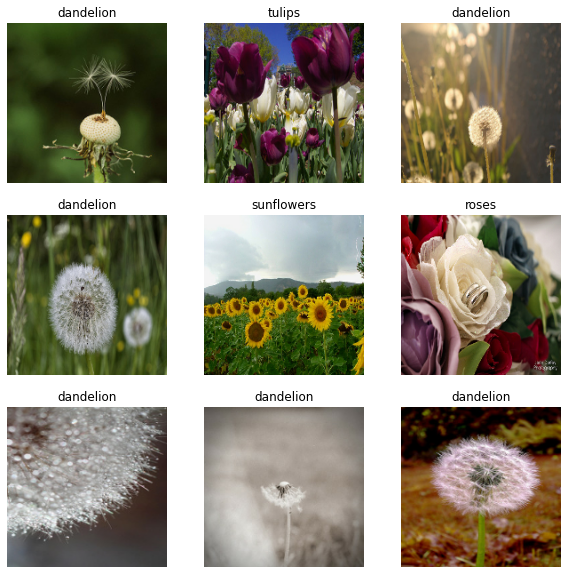

In [11]:
# Display several images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Images contain several objects and different background, which may harden the classification task.

Number of data per class:

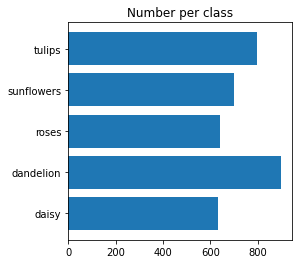

In [12]:
# Number of samples per class
data_dir = pathlib.Path(data_dir)

class_counts = []
for class_name in class_names:
    class_count = len(list(data_dir.glob(class_name+'/*.jpg')))
    class_counts.append(class_count)

plt.figure(figsize=(4,4))
plt.barh(class_names, class_counts)
plt.title('Number per class')
plt.show()

### Data augmentation

Data augmentation is performed using random flip,  rotation and zooming:

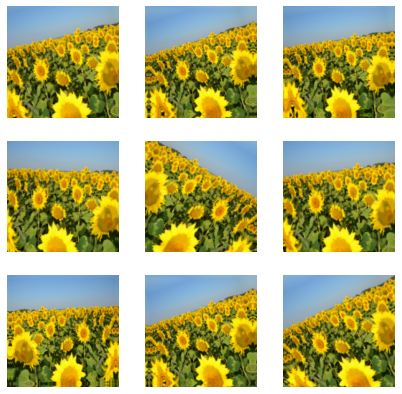

In [13]:
# Data augmentation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

# Data augmentation example
plt.figure(figsize=(7, 7))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


Callback for early stopping:

In [14]:
# Early stopping based on a given metric
earlystop_cb = keras.callbacks.EarlyStopping(
    patience=10, 
    monitor='val_accuracy',
    restore_best_weights=True)

callbacks = [earlystop_cb]


Loading function to load test set for model evaluation

In [15]:
# Load test data from test dataset. 
def get_imgs_from_dataset(ds_test, ds_test_size):
    # Take images from data set ds_test: (data_test, data_test_noisy) 
    data_test = []
    label_test = []
    count = 0
    for img, label in ds_test.take(ds_test_size):
        data_test_this = img.numpy()  
        label_test_this = label.numpy() 
        if count == 0:
            data_test = data_test_this
            label_test = label_test_this
            count = 1
        else:            
            data_test = np.append(data_test, data_test_this, axis=0)
            label_test = np.append(label_test, label_test_this, axis=0)
    return data_test, label_test
    
# Test data
data_test, label_test = get_imgs_from_dataset(val_ds, len(val_ds)-1)

## Model, training and assessment: A transfer learning with fine tuning approach followed by ensemble voting

### Create the model

We use transfer learning using a pretrained model that has been trained on a very large dataset (ImageNet). We try to different models: 'Xception' which provides a high top-5 accuracy (with 20 M parameters) and 'MobileNetV2' which provides great accuracy for a relatively small model size. 

We load the model but skip the 'top' layer to tailored our model to the classes in the dataset. Then, we freeze their layers to train on a small dataset. We also define the model and specify their preprocessing steps. 

Instead of creating and training the model, you can load the trained model: run the code below.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Number of layers in the base model:  132
Epoch 42/170
92/92 [==============================] - 23s 201ms/step - loss: 0.3229 - accuracy: 0.8849 - val_loss: 0.3344 - val_accuracy: 0.8665
Epoch 43/170
92/92 [==============================] - 18s 195ms/step - loss: 0.2771 - accuracy: 0.9009 - val_loss: 0.2978 - val_accuracy: 0.8874
Epoch 44/170
92/92 [==============================] - 18s 194ms/step - loss: 0.2368 - accuracy: 0.9142 - val_loss: 0.2855 - val_accuracy: 0.8927
Epoch 45/170
92/92 [==============================] - 18s 194ms/step - loss: 0.2139 - accuracy: 0.9234 - val_loss: 0.2728 - val_accuracy: 0.9058
Epoch 46/170
92/92 [==============================] - 18s 194ms/step - loss: 0.1827 - accuracy: 0.9370 - val_loss: 0.2664 - val_accuracy: 0.9005
Epoch 47/170
92/92 [==============================] - 18s 194ms/step - loss: 0.1683 - accuracy: 0.9384 - val_loss: 0.2685 - val_accuracy: 0.9031
Epoch 48/170
92/92 [==============================] - 18s 194ms/step - loss: 0.1457 - acc

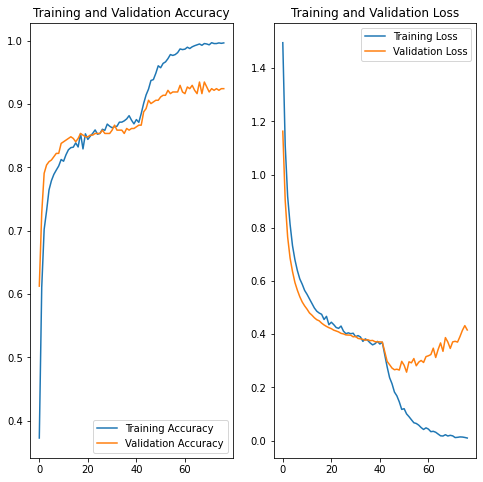

Accuracy for Xception with fine tuning is 0.93


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Number of layers in the base model:  132
Epoch 33/170
92/92 [==============================] - 23s 201ms/step - loss: 0.3541 - accuracy: 0.8682 - val_loss: 0.3268 - val_accuracy: 0.8639
Epoch 34/170
92/92 [==============================] - 18s 195ms/step - loss: 0.2976 - accuracy: 0.8951 - val_loss: 0.3217 - val_accuracy: 0.8770
Epoch 35/170
92/92 [==============================] - 18s 195ms/step - loss: 0.2560 - accuracy: 0.9087 - val_loss: 0.2848 - val_accuracy: 0.8848
Epoch 36/170
92/92 [==============================] - 18s 194ms/step - loss: 0.2176 - accuracy: 0.9200 - val_loss: 0.2970 - val_accuracy: 0.8927
Epoch 37/170
92/92 [==============================] - 18s 194ms/step - loss: 0.2003 - accuracy: 0.9322 - val_loss: 0.2676 - val_accuracy: 0.9058
Epoch 38/170
92/92 [==============================] - 18s 194ms/step - loss: 0.1788 - accuracy: 0.9326 - val_loss: 0.2884 - val_accuracy: 0.8953
Epoch 39/170
92/92 [==============================] - 18s 194ms/step - loss: 0.1525 - acc

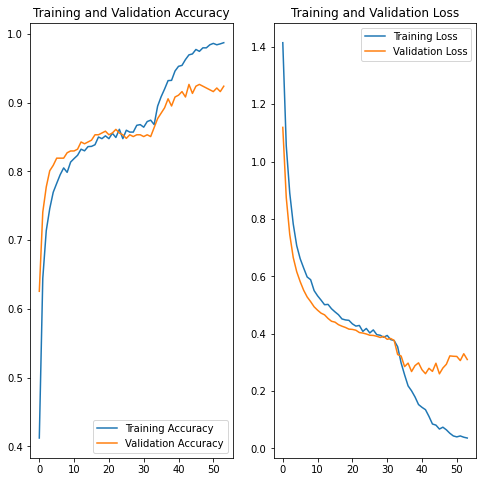

Accuracy for Xception with fine tuning is 0.93
Number of layers in the base model:  132
Epoch 68/170
92/92 [==============================] - 23s 201ms/step - loss: 0.2815 - accuracy: 0.8931 - val_loss: 0.3005 - val_accuracy: 0.8953
Epoch 69/170
92/92 [==============================] - 18s 195ms/step - loss: 0.2348 - accuracy: 0.9131 - val_loss: 0.2970 - val_accuracy: 0.8874
Epoch 70/170
92/92 [==============================] - 18s 194ms/step - loss: 0.2107 - accuracy: 0.9251 - val_loss: 0.3083 - val_accuracy: 0.8927
Epoch 71/170
63/92 [===================>..........] - ETA: 5s - loss: 0.1802 - accuracy: 0.9348

In [ ]:
# Number of models for ensemble voting
import json
num_ensemble = 10
test_acc_ensembles = []
for i_ensemble in range(num_ensemble):
  IMG_SHAPE = (img_height, img_width) + (3,)

  # Download pretrained base model
  base_model_name = 'Xception' # mobilenet_v2, Xception, vgg16
  if base_model_name == 'mobilenet_v2':
      # mobilenet_v2: small networks
      # Param M: 4.24, top-1 acc: 70.9, top-5 acc:	89.9
      # Imagenet ILSVRC-2012-CLS 
      # Timing: # GTX: 7s and 3s, FT: 
      base_model = tf.keras.applications.MobileNetV2(
              input_shape=IMG_SHAPE,                                                   
              include_top=False,                                                   
              weights='imagenet')
      preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input    
  elif base_model_name == 'Xception':
      # Xception
      # 20 M parameters
      # no smaller than 71. E.g. (150, 150, 3) 
      # Timing: # GTX: 10s and 6s, FT: 15s and 9s
      base_model = keras.applications.Xception(
              input_shape=IMG_SHAPE,                                                   
              include_top=False,                                                   
              weights='imagenet')
      preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

  # Freeze weights
  base_model.trainable = False

  # Average pooling layer to pass from block 6x6x1280 to vector 1x1280
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # Multiclass classification layer
  prediction_layer = tf.keras.layers.Dense(num_classes)

  # Create the model
  inputs = tf.keras.Input(shape=(img_height, img_width, 3))
  # Data augmentation
  x = data_augmentation(inputs)
  # Normalize images
  x = preprocess_input(x)        
  # base_model in inference mode by passing `training=False'
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)

  # Compile the model
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  # Train a large number of steps with early stopping criterion
  epochs=100
  history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, 
                      callbacks=callbacks, verbose = 0)

  # Display loss and accuracy
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # FINE TUNING
  # Unfreeze the base model
  base_model.trainable = True

  # Number layers are in the base model
  print("Number of layers in the base model: ", len(base_model.layers))

  # Fine-tune from this layer onwards
  fine_tune_at = 70

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
      layer.trainable =  False
      
  # Recompile your model after you make any changes
  model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate/10),  # Lower learning rate
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  # Train (continue training)
  fine_tune_epochs = 70
  total_epochs = epochs + fine_tune_epochs    
  history_fine = model.fit(train_ds,
                            epochs=total_epochs,
                            initial_epoch=history.epoch[-1],
                            validation_data=val_ds,
                            callbacks=callbacks,
                           verbose=0)

  # Display losses
  acc += history_fine.history['accuracy']
  val_acc += history_fine.history['val_accuracy']

  loss += history_fine.history['loss']
  val_loss += history_fine.history['val_loss']

  epochs_range = range(len(acc))
  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  #
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

  # Predict 
  data_pred = model.predict(data_test)
  data_pred_class = np.argmax(data_pred, axis=1)

  acc_fn = tf.keras.metrics.Accuracy()
  test_acc = acc_fn(data_pred_class, label_test)
  print('Accuracy for %s with fine tuning is %.2f' % (base_model_name, test_acc))
  test_acc_ensembles.append(test_acc)

  # Save the model in H5 format (default).
  name_save = 'flower_photos_' + base_model_name + '_TF' + str(history.epoch[-1]) +'it' + '_FTat' + str(fine_tune_at) + '_it' + str(history_fine.epoch[-1]) + '_Ens' + str(i_ensemble) 
  model.save(os.path.join(save_dir, name_save + ".h5"))

  # Save history
  with open(os.path.join(save_dir, name_save + '.json'), 'w') as file:
    json.dump(history_fine.history, file)

### Ensemble assessment 

In [ ]:
juan

## Final analysis and image exploration

To analyze the final results we build the confusion matrix. 

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd

def confusion_matrix_analysis(label_test, data_pred_class, class_names):
    confusion_mat = confusion_matrix(label_test, data_pred_class)
    confusion_df = pd.DataFrame(confusion_mat, columns=class_names, index=class_names)
    print('Confusion matrix (row: true, columns: predictions):')
    print(confusion_df)
    # Largest errors: roses as tulips, daisy as tulips, dandelion as tulips
    
    # Confusion matrix off-diagonals
    confusion_mat_off = np.copy(confusion_mat)
    np.fill_diagonal(confusion_mat_off, 0)
    confusion_as = np.sum(confusion_mat_off, axis=0)
    confusion_as_df = pd.Series(confusion_as, index=class_names)
    print('')
    print('Missclassified as ...')
    print(confusion_as_df)
    # flowers are misclassified mostly as tulips, 
    # so tulips images must be revisited 
    # dandelion presents the lowest (most data)
    
    confusion_for = np.sum(confusion_mat_off, axis=1)
    confusion_for_df = pd.Series(confusion_for, index=class_names)
    print('')
    print('Missclassifications for ...')
    print(confusion_for_df)
    # while tulips are the flower with lowest number of errors
    return confusion_df, confusion_as_df, confusion_for_df

confusion_df, confusion_as_df, confusion_for_df = confusion_matrix_analysis(label_test, data_pred_class, class_names)


Confusion matrix (row: true, columns: predictions):
            daisy  dandelion  roses  sunflowers  tulips
daisy          58          0      0           0       2
dandelion       1         84      0           3       2
roses           0          0     60           0       3
sunflowers      0          1      4          64       1
tulips          0          0      1           0      68

Missclassified as ...
daisy         1
dandelion     1
roses         5
sunflowers    3
tulips        8
dtype: int64

Missclassifications for ...
daisy         2
dandelion     6
roses         3
sunflowers    6
tulips        1
dtype: int64


We get almost perfect classification for *tulips*. *Daisies* and *roses* are also well classified. *Sunflowers* and *dandelions* have the largest errors, which should be investigated. 

We display the misclassified results for analysis.

Misclassified images for daisy


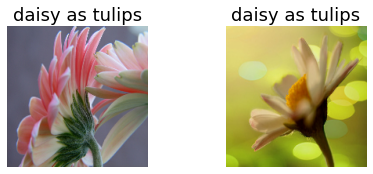

Misclassified images for dandelion


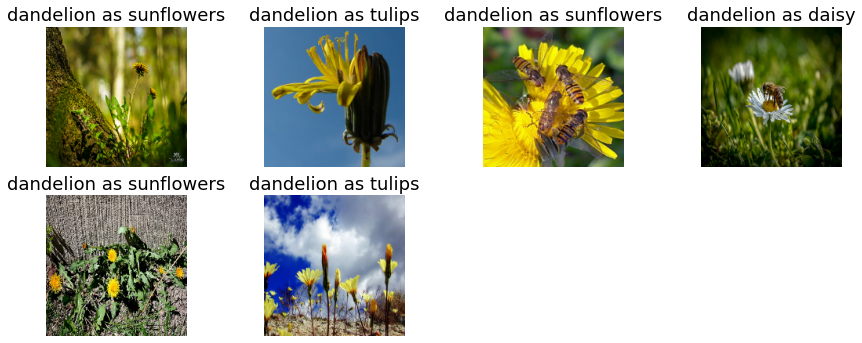

Misclassified images for roses


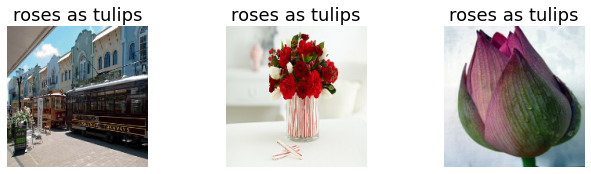

Misclassified images for sunflowers


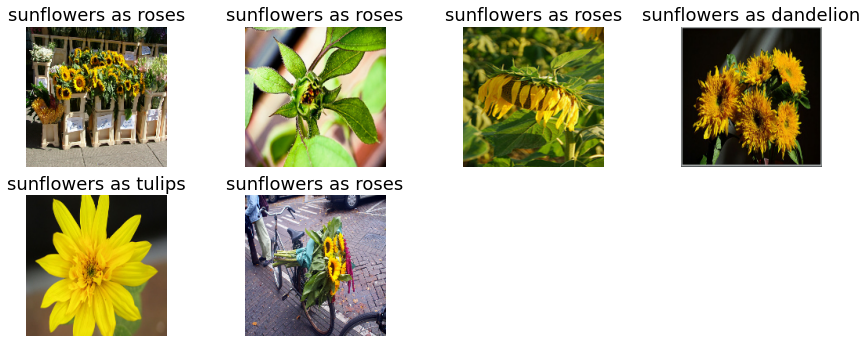

Misclassified images for tulips


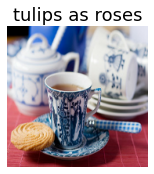

In [ ]:
# Explore misclassified results 
def display_misclassified_images(data_test, label_test, data_pred_class, class_names, misclassified_only=True):
    test_misclassified = [i for i in range(len(label_test)) if (data_pred_class[i] != label_test[i])]
    classes_misclassified = []
    for class_ind, class_name in enumerate(class_names):
        label_test[test_misclassified] == class_ind
        class_misclassified = [i for i in range(len(label_test)) 
            if (data_pred_class[i] != label_test[i])
            and (label_test[i] == class_ind)]
        classes_misclassified.append(class_misclassified)
        
        # Display misclassified images for each class
        print('Misclassified images for ' + class_name)
        plt.figure(figsize=(15, 15))
        for i in range(min(20,len(class_misclassified))):
            ax = plt.subplot(5, 4, i + 1)
            data_test_ind = class_misclassified[i]
            plt.imshow(data_test[data_test_ind].astype("uint8"))
            plt.title(class_names[label_test[data_test_ind]] + ' as ' + class_names[data_pred_class[data_test_ind]],
                      fontsize=18)
            plt.axis("off")
        plt.show()
        
        if misclassified_only is False:
            # Display well classified results for comparison
            class_well_classified = [i for i in range(len(label_test)) 
                if (data_pred_class[i] == label_test[i])
                and (label_test[i] == class_ind)]
            print('Well classified images for ' + class_name)
            plt.figure(figsize=(15, 15))
            for i in range(min(20,len(class_well_classified))):
                ax = plt.subplot(5, 4, i + 1)
                data_test_ind = class_well_classified[i]
                plt.imshow(data_test[data_test_ind].astype("uint8"))
                plt.title(class_names[label_test[data_test_ind]] + ' as ' + class_names[data_pred_class[data_test_ind]],
                          fontsize=18)
                plt.axis("off")
            plt.show()

# Display misclassified results
display_misclassified_images(data_test, label_test, data_pred_class, class_names)

This display raises the following comments for further analysis: 
* **Daisies**: The first image shows that daisies with pink color (not white) can be misclassified. The second image shows that a strong yellow background with reflections hardens the problem. 
This could explained that are misclassified as tuilips. 

* **Dandelions**: Yellow dandelions are misclassified as sunflowers and white dandelions as daisies. 

* **Roses**: The first image is too hard. The others should be well classified (second for the background and the third one because of the zoom).

* **Sunflowers**: Misclassification of sunflowers as roses 
do not make sense; maybe, it is caused of the backgound. 
Looking at the features that are activated may help. 
One of the images does not have flower, which raises the question if the classifier is also learning the leave type for each class.

* **Tulips**: the image seems wrong. We should check the test and training set to remove wrongly labeled images.

Some of these misclassifications changed when re-training the model from scratch or using different base model, which encourages to use ensemble methods for futher accuracy. 

### Asses on new acquired data

We further assess the trained model on new images acquired with a mobile. 

### Conclusions and further analysis

We have obtained an accurate classifier that reached $95$ % accuracy on a relatievely small data set using the 'Xception' model (we obtain $93$ % using the 'MobileNetV2' model using the same procedure; model saved in 'Results' folder). Furter analysis should be considered for final accuracy quantification, maybe using generalized cross validation. 

Further work should focus on pursuing the misclassifications:
* From the results obtained, ensemble methods may lead to futher accuracy, as different models misclassified different images. 

* Images that were consistently misclassified, such as daisies, were due to color resembles to other classes, which could be improved. * Misclassifications due to zooms and backgrounds could be investigate by looking at activations of features. 

* Cleaning the data set and doing GCV could also help due the size of the dataset. 

* Working on the data rather than on the model seem to be a current approach to further improve results on the community. 

* It would be also nice to visualize the data using an embedding (eg. embedding projector on TF).

An error table that includes the different possible sources of errors and their ocurrence should provide an ordered list of priorities. 

 